In [1]:
!pip install --upgrade atlas-schema

In [2]:
import awkward as ak
import vector
import hist
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import uproot

from atlas_schema.schema import NtupleSchema
from coffea import dataset_tools
from coffea.nanoevents import NanoEventsFactory

import atlasopenmagic

vector.register_awkward()
mplhep.style.use(mplhep.style.ATLAS1)

In [3]:
!pip install servicex
from servicex import dataset, query, deliver

## Getting the data 
 ####    Opendata on local file system for this mini-demo 

In [17]:
fileset = {
    "Zprimett": {
        "files": {"/tmp/38191516._000001.root": "reco"},
        "metadata": {"meta": 0}
    },
    "ttbar": {
        "files": {
            "/tmp/37620644._000013.root": "reco"},
        "metadata": {"meta": 0}
    }
}

#### Ultimately, we will make use of ServiceX
- Fetch centrally produced data (ntuple) with Rucio
- Apply selection cuts
- Optional:
    - run TopCPToolKit in the backend
        - Produce ntuples from Physlite 
        - amount of allowed systematic computing TBD

Interface example:

In [18]:
#1) Build dataset 
rucio_did="user.acordeir:nominal_trig_overlap_obj_dump_sys_zprime3k.root"
ds=dataset.Rucio(rucio_did)

#2) Write transformation
ds_query = query.UprootRaw(
    [
        {
            "treename": "reco",
            "filter_name": ["jet_pt*", "el_pt*"], 
            "cut": "num(el_pt_NOSYS)>0",
        }
    ]
)

#3) Write deliver config
spec = {
    "Sample": [{"Name": "from_rucio", "Dataset": ds, "Query": ds_query}],
}

#4) Get the data 
delivered_file = deliver(spec, ignore_local_cache=True)

#fileset["rucio_signal"]={
#    "files": {delivered_file["from_rucio"][0]: "servicex"},
#    "metadata": {"meta": 0}
#}

Output()

## NanoEventsFactory
 - Lazy loading with virtual arrays 
 - Ntuple ATLAS schema for tracking systematic uncertainty branches

In [19]:
events = NanoEventsFactory.from_root(fileset["Zprimett"]["files"], mode="virtual", schemaclass=NtupleSchema).events()

/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: Missing event_ids : ['dataTakingYear', 'lumiBlock', 'mcEventWeights']
  self._build_collections(self._form["fields"], self._form["contents"])
/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: I found a collection with no defined mixin: 'globalTriggerMatch'. I will assume behavior: 'Systematic'. To suppress this warning next time, please define mixins for your custom collections. [mixin-undefined]
  self._build_collections(self._form["fields"], self._form["contents"])
/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: I found a collection with no defined mixin: 'globalTriggerEffSF'. I will assume behavior: 'NanoCollection'. To suppress this warning next time, please define mixins for your custom collections. [mixin-undefined]
  self._build_collections(self._form["fields"], self._form["contents"])


#### ATLAS systematic handling has never been so easy!

In [20]:
#access list of systematic branches
events.systematic_names[0:3]

['NOSYS', 'EG_RESOLUTION_AF3__1down', 'EG_RESOLUTION_AF3__1up']

In [21]:
f"Ntuple contains {len(events.systematic_names)} systematics"

'Ntuple contains 313 systematics'

### Easily access specific variations and evaluate them

In [22]:
jer_variations=[s for s in events.systematic_names if "JER" in s]

Text(0, 1, 'Entries')

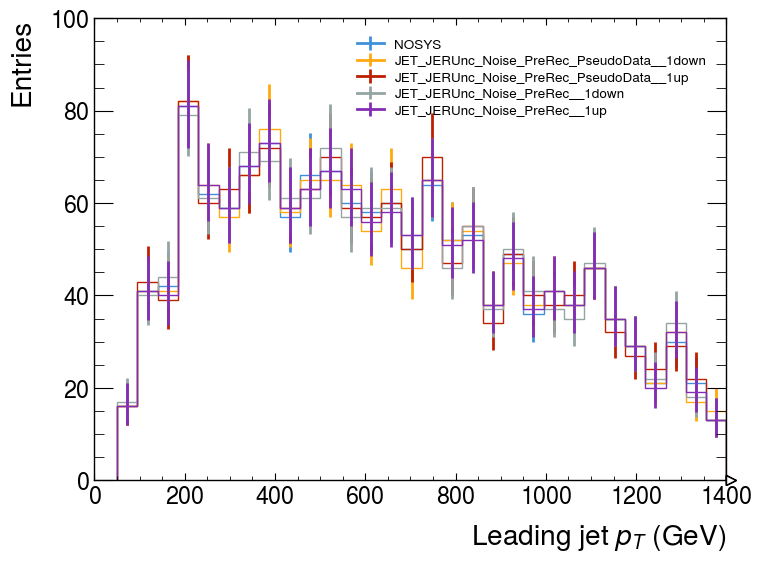

In [23]:
h = hist.new.Regular(30, 50, 1400, label="Leading jet $p_T$ (GeV)").StrCat([], name="variation", growth=True).Double()

for variation in ["NOSYS"] + jer_variations[0:4]:
    event_view = events[variation]
    h.fill(event_view.jet.pt[:, 0] / 1_000, variation=variation)


fig, ax = plt.subplots()
for variation in h.axes[1]:
    h[:, variation].plot(histtype="step", label=variation, ax=ax)
    
ax.legend(fontsize="x-small", loc=1)
ax.set_ylabel("Entries")

## Coffea processor approach 
#### Distributed workers in the AF 

In [24]:
from dask.distributed import Client, PipInstall

client = Client("tls://localhost:8786")

plugin = PipInstall(packages=["atlas_schema", "atlasopenmagic"], pip_options=["--upgrade"])
client.register_plugin(plugin)

#### Fill histograms and apply xsec normalisation for nominal + variations

In [25]:
from coffea import processor

import atlasopenmagic

def get_xsec_norm(dsid):
    # not including normalization by sum of weights (that one depends on the number of files processed)
    lumi = 36646.74 # / pb
    meta = atlasopenmagic.get_metadata(dsid)
    return lumi * meta["cross_section_pb"] * meta["kFactor"] * meta["genFiltEff"]


class Analysis(processor.ProcessorABC):
    def __init__(self):
        self.h = hist.new.Regular(12, 0, 300, label="leading jet $p_T$").\
            StrCat([], name="dsid", growth=True).StrCat([], name="variation", growth=True).\
            Weight()

    def process(self, events):
        f = uproot.open(events.metadata["filename"])
        sim_type, mc_campaign, dsid, etag = f["metadata"].axes[0]
        sumw = float(f[f"CutBookkeeper_{dsid}_284500_NOSYS"].values()[1])  # initial sum of weights
        systematics_from_hist = list(f["listOfSystematics"].axes[0])
        list_of_variations =  events.systematic_names
        # ensure systematics in schema and in histogram match
        assert sorted(systematics_from_hist) == sorted(list_of_variations)  

        # run over subset of systematics
        for variation in ["NOSYS"] + [sys for sys in events.systematic_names if sys.startswith("JET_JER_EffectiveNP_1_")]:
            print(variation)
            event_view = events[variation]
            self.h.fill(event_view.jet.pt[:, 0] / 1_000, dsid=dsid, variation=variation, weight=event_view.weight.mc)
        return {
            "hist": self.h,
            "meta": {
                "sumw": {dsid: {(events.metadata["fileuuid"], sumw)}}}  # sumw in set to avoid summing
        }  

    def postprocess(self, accumulator):
        # normalize histograms
        # https://topcptoolkit.docs.cern.ch/latest/starting/running_local/#sum-of-weights
        for dsid in accumulator["hist"].axes[1]:
            norm = get_xsec_norm(dsid) / sum([sumw for uuid, sumw in accumulator["meta"]["sumw"][dsid]])
            accumulator["hist"][:, dsid, :] = np.stack([accumulator["hist"][:, dsid, :].values()*norm, accumulator["hist"][:, dsid, :].variances()*norm**2], axis=-1)


#### Configure: 
- data chunk size
- processor executor type
- schema with systematic handles

In [26]:
run = processor.Runner(
    executor = processor.IterativeExecutor(),
    schema=NtupleSchema,
    savemetrics=True,
    chunksize=50000
)
samples = run.preprocess(fileset)

out, report = run(samples, processor_instance=Analysis())

out, report

Output()

/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: Missing event_ids : 
['dataTakingYear', 'lumiBlock', 'mcEventWeights']
  self._build_collections(self._form["fields"], self._form["contents"])

/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: I found a collection with no 
defined mixin: 'globalTriggerMatch'. I will assume behavior: 'Systematic'. To suppress this warning next time, 
please define mixins for your custom collections. [mixin-undefined]
  self._build_collections(self._form["fields"], self._form["contents"])

/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: I found a collection with no 
defined mixin: 'globalTriggerEffSF'. I will assume behavior: 'NanoCollection'. To suppress this warning next time, 
please define mixins for your custom collections. [mixin-undefined]
  self._build_collections(self._form["fields"], self._form["contents"])

NOSYS

JET_JER_EffectiveNP_1_PseudoData__1down

JET_JER_EffectiveNP_1_PseudoData__1up

JET_JER_EffectiveNP_1__1down

JET_JER_EffectiveNP_1__1up

NOSYS

JET_JER_EffectiveNP_1_PseudoData__1down

JET_JER_EffectiveNP_1_PseudoData__1up

JET_JER_EffectiveNP_1__1down

JET_JER_EffectiveNP_1__1up

({'hist': Hist(
    Regular(12, 0, 300, label='leading jet $p_T$'),
    StrCategory(['410470', '301333'], growth=True, name='dsid'),
    StrCategory(['NOSYS', 'JET_JER_EffectiveNP_1_PseudoData__1down', 'JET_JER_EffectiveNP_1_PseudoData__1up', 'JET_JER_EffectiveNP_1__1down', 'JET_JER_EffectiveNP_1__1up'], growth=True, name='variation'),
    storage=Weight()) # Sum: WeightedSum(value=6.75018e+06, variance=7.5583e+08) (WeightedSum(value=8.49445e+06, variance=2.05141e+09) with flow),
  'meta': {'sumw': {'410470': {('d002a250-76ef-11f0-bf34-f18ca8c0beef',
      109523312.0)},
    '301333': {('551e0c5c-76de-11f0-8d75-fa8ca8c0beef', 30000.0)}}}},
 {'bytesread': 3778280,
  'columns': ['jet_select_baselineJvt_JET_JER_EffectiveNP_1__1up',
   'jet_pt_JET_JER_EffectiveNP_1_PseudoData__1down',
   'jet_select_baselineJvt_JET_JER_EffectiveNP_1_PseudoData__1up',
   'jet_select_baselineJvt_JET_JER_EffectiveNP_1__1down',
   'jet_pt_JET_JER_EffectiveNP_1_PseudoData__1up',
   'weight_mc_NOSYS',
   'jet_pt

#### Hist plotting with normalisations 

1 JET_JER_EffectiveNP_1_PseudoData__1down
2 JET_JER_EffectiveNP_1_PseudoData__1up
3 JET_JER_EffectiveNP_1__1down
4 JET_JER_EffectiveNP_1__1up


/tmp/ipykernel_1042/3906161869.py:16: RuntimeWarning: invalid value encountered in divide
  ratio = (h[:, dsid, variation].values() / h[:, dsid, "NOSYS"].values())


(0.8, 1.2)

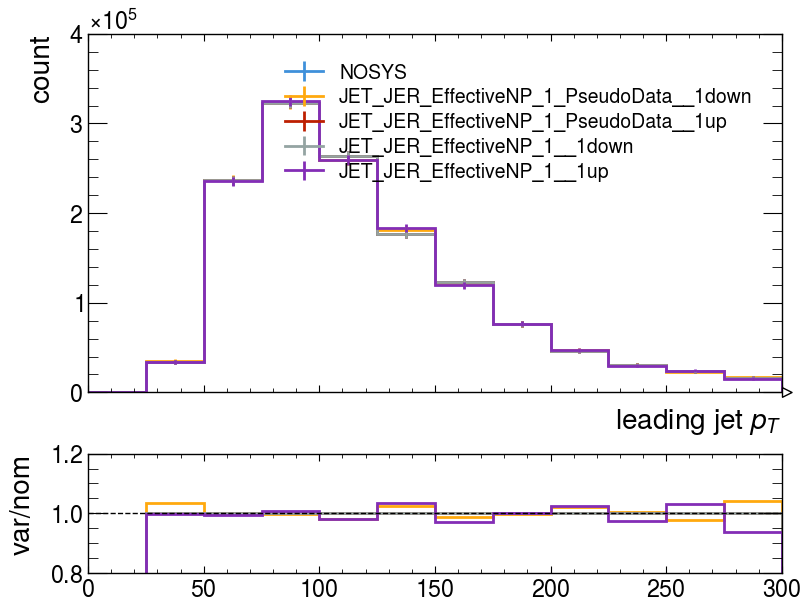

In [27]:
dsid = "410470"
h = out["hist"]

fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=(3, 1), constrained_layout=True, sharex=True)
h[:, dsid, :].plot(ax=ax1, linewidth=2)
ax1.legend()
ax1.set_ylabel("count")

edges = h[:, dsid, :].axes[0].edges
ax2.plot(edges, [1]*len(edges), color="black", linestyle="dashed", linewidth=1)
for ivar, variation in enumerate(h.axes[2]):
    if variation == "NOSYS":
        continue
    print(ivar, variation)
    # print(h[:, dsid, variation], 
    ratio = (h[:, dsid, variation].values() / h[:, dsid, "NOSYS"].values())
    ax2.stairs(ratio, edges, color=f"C{ivar}", linewidth=2)
ax2.set_ylabel("var/nom")
ax2.set_ylim([0.8, 1.2])

#### Save the preprocess metrics 

In [28]:
import base64
import dataclasses
import json
import coffea


def write_samples(samples, fname):
    # encode bytes
    serializable = []
    for s in samples:
        chunk = dataclasses.asdict(s)
        chunk["fileuuid"] = base64.b64encode(chunk["fileuuid"]).decode("ascii")
        serializable.append(chunk)
    
    with open(fname, "w") as f:
        json.dump(serializable, f)


def read_samples(fname):
    with open(fname) as f:
        samples = json.load(f)
    
    # decode bytes
    for i in range(len(samples)):
        samples[i]["fileuuid"] = base64.b64decode(samples[i]["fileuuid"])
        samples[i] = coffea.processor.executor.WorkItem(**samples[i])

    return samples


samples = run.preprocess(fileset)
write_samples(samples, "samples.json")
samples = read_samples("samples.json")

samples


[WorkItem(dataset='ttbar', filename='/tmp/37620644._000013.root', treename='reco', entrystart=0, entrystop=12663, fileuuid=b'\xd0\x02\xa2Pv\xef\x11\xf0\xbf4\xf1\x8c\xa8\xc0\xbe\xef', usermeta={'meta': 0}),
 WorkItem(dataset='Zprimett', filename='/tmp/38191516._000001.root', treename='reco', entrystart=0, entrystop=1458, fileuuid=b'U\x1e\x0c\\v\xde\x11\xf0\x8du\xfa\x8c\xa8\xc0\xbe\xef', usermeta={'meta': 0})]

## Would be followed by Statistical modeling 
### Cabinatery, PyHF, TRexFitter